# Data Analysis

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO and WARNING messages


In [11]:

# Path to the dataset folder
dataset_path = '/kaggle/input/kidney-imgae-dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Dictionary to hold counts
image_counts = {}

# Loop through each subfolder (class)
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        # Count number of files in the folder
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        image_counts[folder_name] = num_images

# Print the counts
for class_name, count in image_counts.items():
    print(f'{class_name}: {count} images')


Cyst: 3709 images
Tumor: 2283 images
Stone: 1377 images
Normal: 5077 images


In [12]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_images(path, title, cmap=None):
    # List all image files in the folder
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    # If less than 10 images, just show all, else sample 10
    sample_size = min(10, len(image_files))
    random_indices = random.sample(range(len(image_files)), sample_size)
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    
    for i, idx in enumerate(random_indices):
        file_path = os.path.join(path, image_files[idx])
        image = Image.open(file_path)
        subplot_row = i // 5
        subplot_col = i % 5
        axes[subplot_row, subplot_col].imshow(image, cmap=cmap)
        axes[subplot_row, subplot_col].axis('off')
    
    # Hide any unused subplots if images < 10
    for j in range(sample_size, 10):
        subplot_row = j // 5
        subplot_col = j % 5
        axes[subplot_row, subplot_col].axis('off')

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()


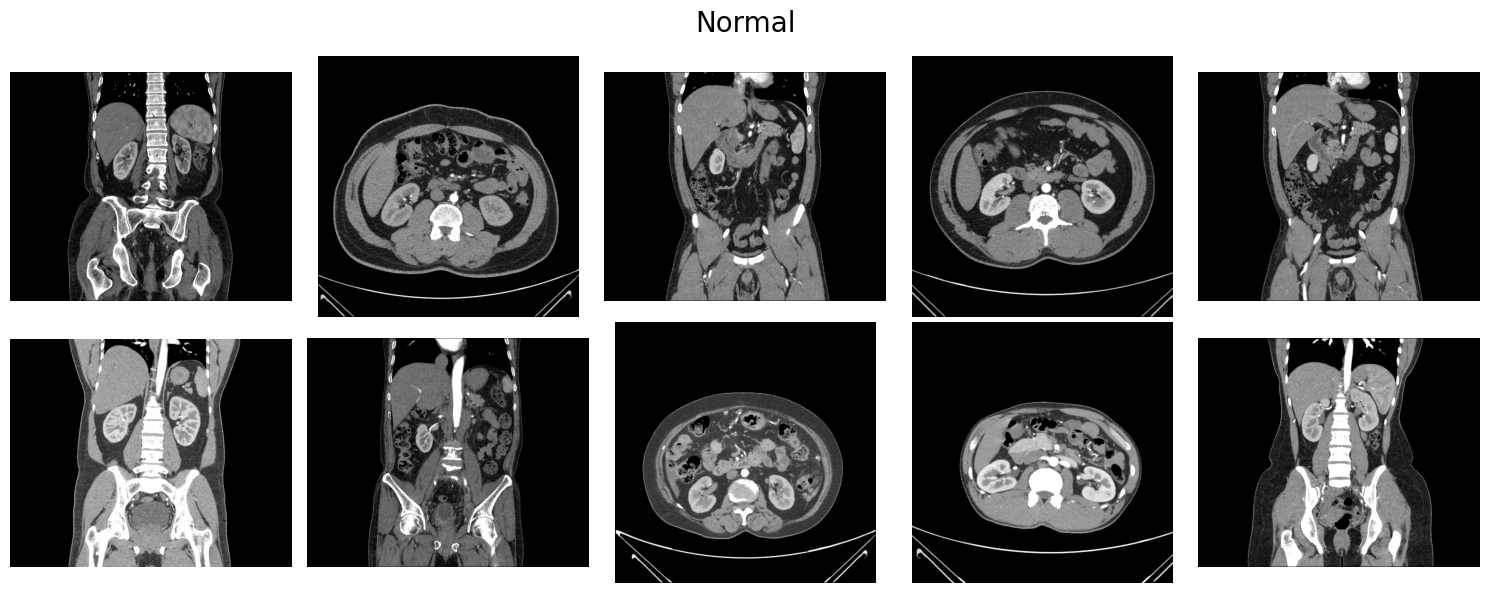

In [13]:
# Healthy Kidney
show_images(os.path.join(dataset_path+"/Normal"),"Normal")

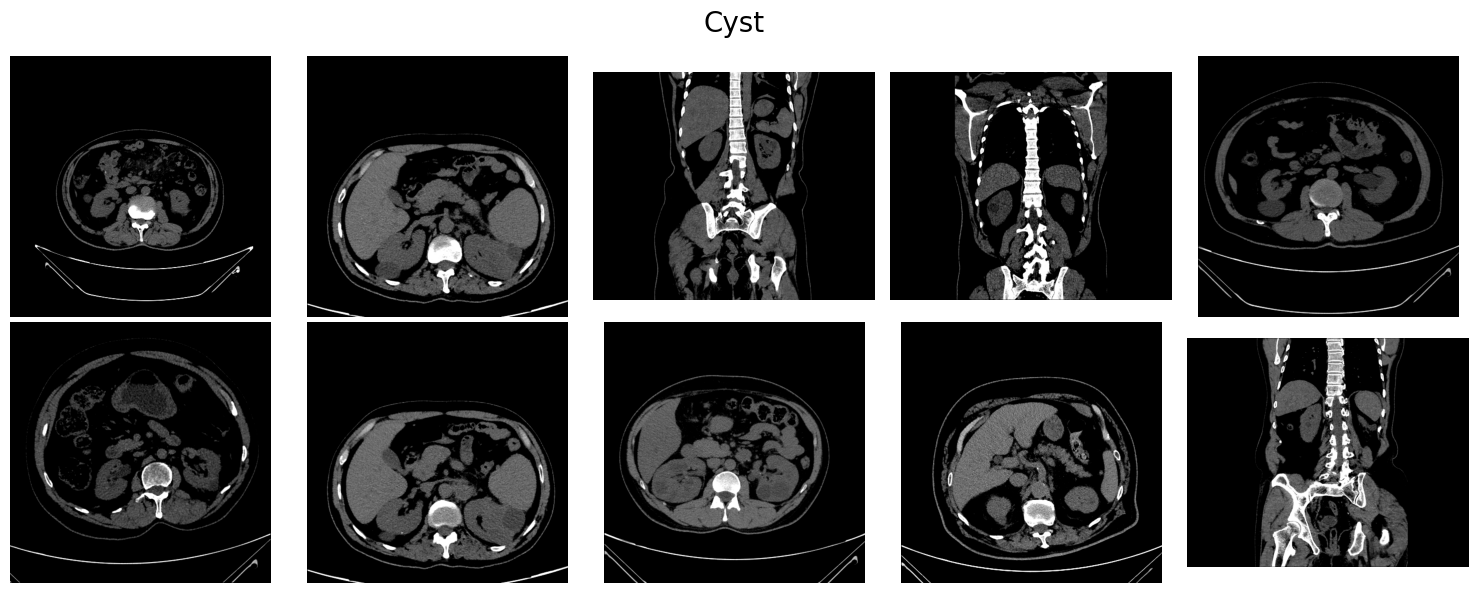

In [14]:
# Cyst
show_images(os.path.join(dataset_path+"/Cyst"),"Cyst")

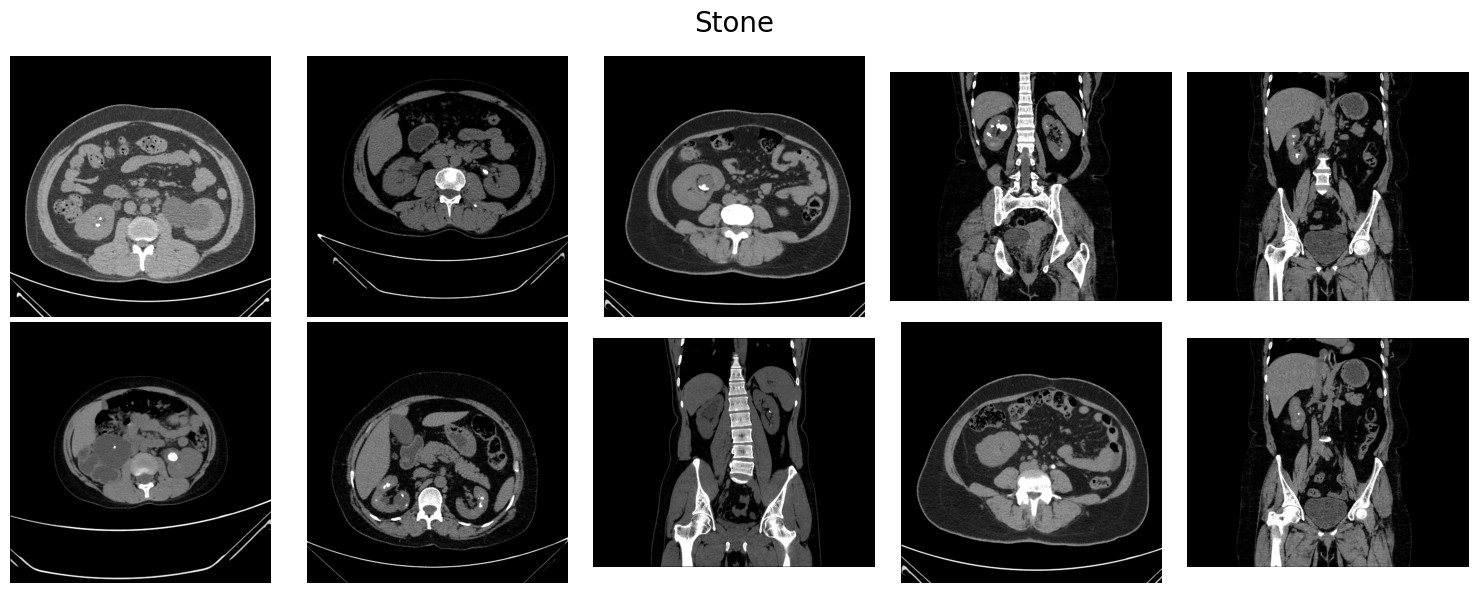

In [15]:
# Stone
show_images(os.path.join(dataset_path+"/Stone"),"Stone")

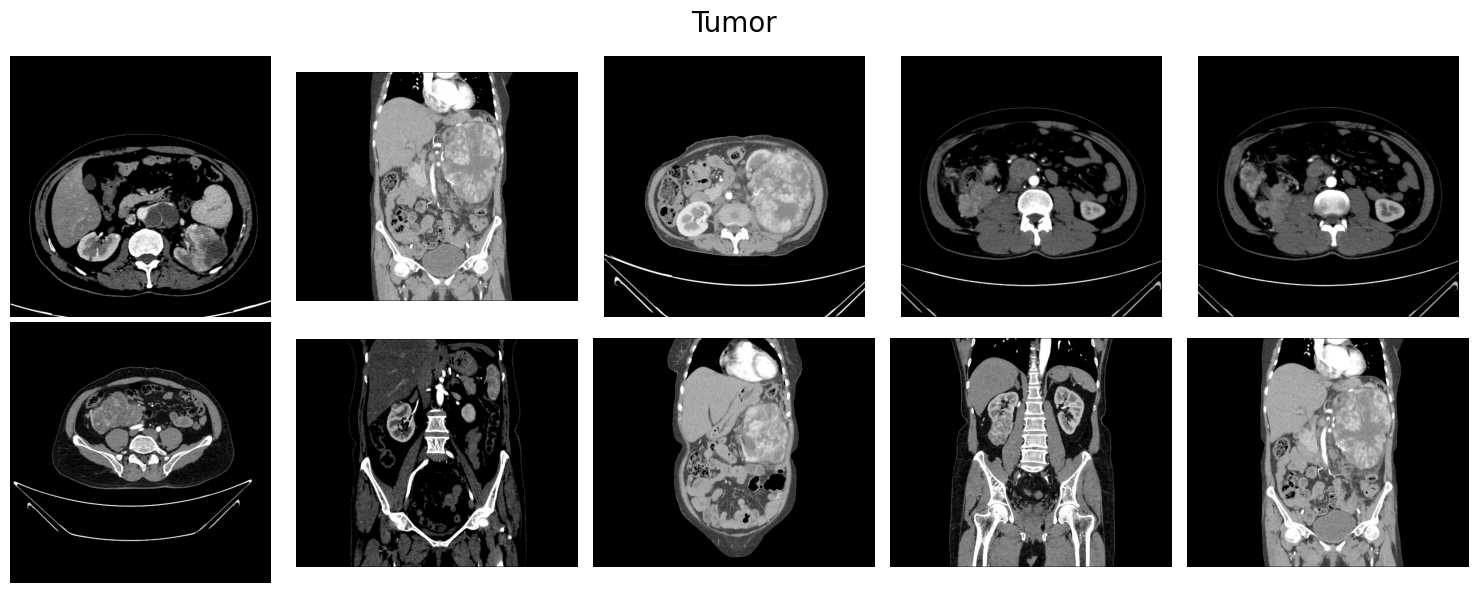

In [16]:
show_images(os.path.join(dataset_path+"/Tumor"),"Tumor")

In [31]:
# === SET PATH ===
dataset_path = "/kaggle/input/kidney-imgae-dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  # Change this to your dataset directory
output_dir = "/kaggle/working/split_dataset"  # Directory to store train, val, test split
os.makedirs(output_dir, exist_ok=True)

# === CREATING TRAIN, VALIDATION, TEST SPLIT ===
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):  
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split dataset: 70% Train, 15% Val, 15% Test
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)


In [32]:
#  IMAGE DATA GENERATORS WITH AUGMENTATION 
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=20,        # Random rotation (0-20 degrees)
    width_shift_range=0.2,    # Random width shift (20% of width)
    height_shift_range=0.2,   # Random height shift (20% of height)
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Random horizontal flip
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for val/test

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Important for evaluation
)

Found 7467 validated image filenames belonging to 4 classes.
Found 2489 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


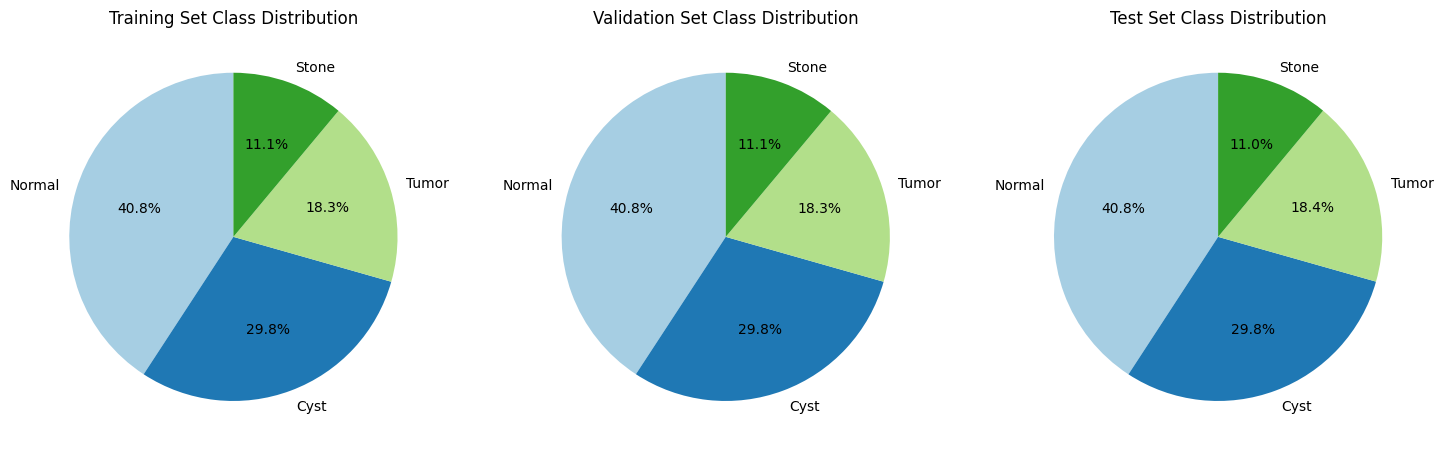

In [33]:
def plot_class_distribution(df, title, subplot_idx):
    class_counts = df["label"].value_counts()
    plt.subplot(1, 3, subplot_idx)
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(title)

plt.figure(figsize=(18, 6))
plot_class_distribution(train_df, "Training Set Class Distribution", 1)
plot_class_distribution(val_df, "Validation Set Class Distribution", 2)
plot_class_distribution(test_df, "Test Set Class Distribution", 3)
plt.show()

In [10]:
IMG_SIZE = 224
BATCH_SIZE = 32


# Vgg19

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split

In [13]:
vgg19_weights_path = "/kaggle/input/kidney_vgg19/tfjs/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Load VGG19 base model with pretrained weights (no top layers)
base_model = VGG19(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.load_weights(vgg19_weights_path)
print("Loaded VGG19 pretrained weights.")


I0000 00:00:1749405020.258946      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749405020.259697      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Loaded VGG19 pretrained weights.


In [15]:
num_classes = 4

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Better than flatten to reduce overfitting
x = Dropout(0.5)(x)              # Dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Number of classes

model = Model(inputs=base_model.input, outputs=output_layer)


In [18]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [45]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_vgg19_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.6845 - loss: 0.7919
Epoch 1: val_accuracy improved from -inf to 0.85416, saving model to best_vgg19_model.h5
234/234 ━━━━━━━━━━━━━━━━━━━━ 122s 521ms/step - accuracy: 0.6845 - loss: 0.7918 - val_accuracy: 0.8542 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 2/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7081 - loss: 0.7309
Epoch 2: val_accuracy did not improve from 0.85416
234/234 ━━━━━━━━━━━━━━━━━━━━ 122s 521ms/step - accuracy: 0.7081 - loss: 0.7309 - val_accuracy: 0.8517 - val_loss: 0.4512 - learning_rate: 0.0010
Epoch 3/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7302 - loss: 0.6971
Epoch 3: val_accuracy improved from 0.85416 to 0.87867, saving model to best_vgg19_model.h5
234/234 ━━━━━━━━━━━━━━━━━━━━ 122s 523ms/step - accuracy: 0.7302 - loss: 0.6971 - val_accuracy: 0.8787 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 4/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7

In [49]:
# Evaluate on train, val, and test sets
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Train Accuracy: 92.65%
Validation Accuracy: 92.04%
Test Accuracy: 92.25%


In [50]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
# Get true labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class label names

# Predict probabilities
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(true_labels, pred_classes, target_names=class_labels))


78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step
Classification Report:

              precision    recall  f1-score   support

        Cyst       0.90      0.99      0.94       742
      Normal       0.94      0.96      0.95      1016
       Stone       0.89      0.64      0.75       275
       Tumor       0.94      0.89      0.91       457

    accuracy                           0.92      2490
   macro avg       0.92      0.87      0.89      2490
weighted avg       0.92      0.92      0.92      2490



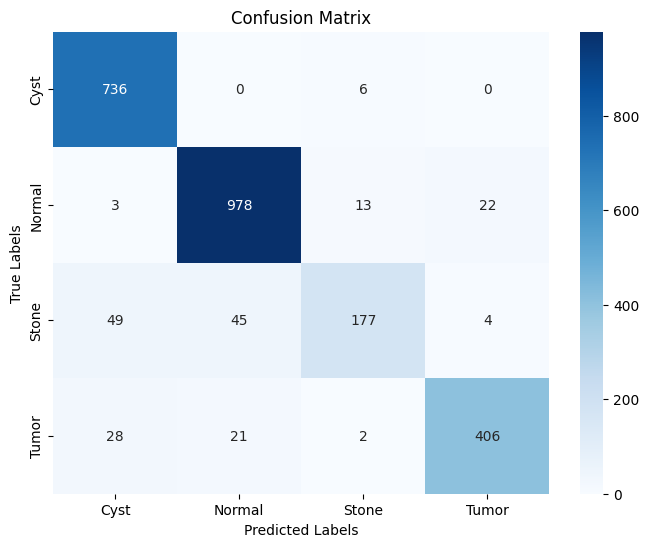

In [51]:
conf_matrix = confusion_matrix(true_labels, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


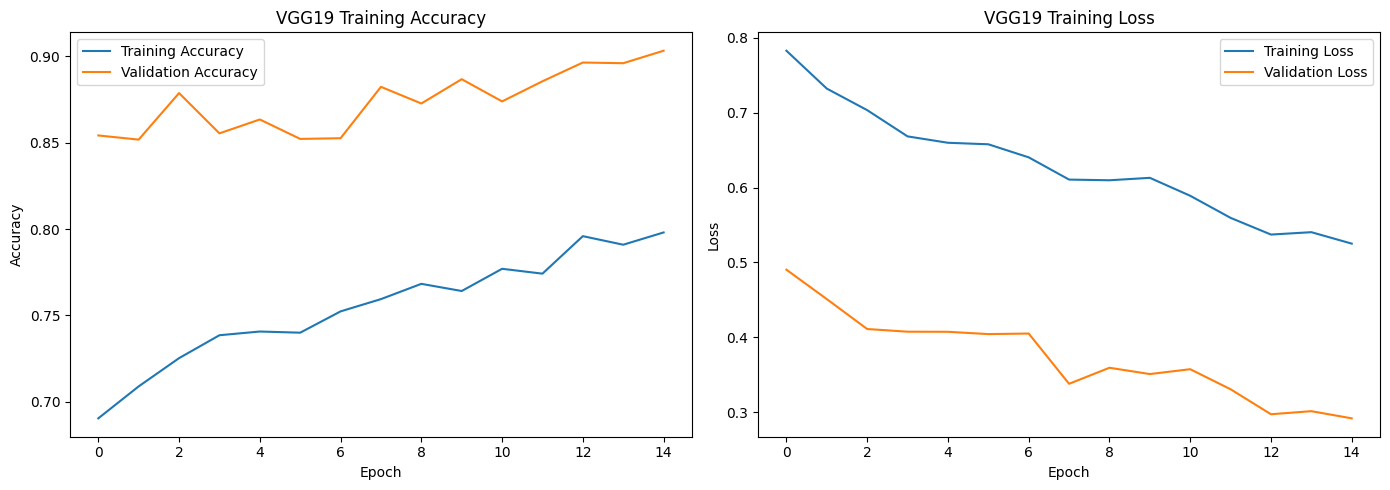

In [53]:
def plot_training(history, title="VGG19 Training"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example call
plot_training(history)


In [19]:
model.save("vgg19_kidney_model.h5")
print("Model saved as vgg19_kidney_model.h5")

Model saved as vgg19_kidney_model.h5


# resnet50

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [21]:
#  use ImageNet weights directly:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

print("Loaded ResNet50 base model.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
num_classes=4

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)


In [23]:
for layer in base_model.layers:
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [60]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_resnet50_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6539 - loss: 0.8390
Epoch 1: val_accuracy improved from -inf to 0.76095, saving model to best_resnet50_model.h5
234/234 ━━━━━━━━━━━━━━━━━━━━ 128s 548ms/step - accuracy: 0.6541 - loss: 0.8387 - val_accuracy: 0.7609 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7545 - loss: 0.6496
Epoch 2: val_accuracy improved from 0.76095 to 0.83045, saving model to best_resnet50_model.h5
234/234 ━━━━━━━━━━━━━━━━━━━━ 110s 468ms/step - accuracy: 0.7545 - loss: 0.6495 - val_accuracy: 0.8305 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7847 - loss: 0.5540
Epoch 3: val_accuracy did not improve from 0.83045
234/234 ━━━━━━━━━━━━━━━━━━━━ 109s 465ms/step - accuracy: 0.7847 - loss: 0.5539 - val_accuracy: 0.8248 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accurac

In [63]:
# Accuracy on Train, Val, Test sets
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print(f"Train Accuracy:      {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy:       {test_acc * 100:.2f}%")


Train Accuracy:      98.50%
Validation Accuracy: 96.71%
Test Accuracy:       95.98%


78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step
Classification Report:

              precision    recall  f1-score   support

        Cyst       0.90      1.00      0.95       742
      Normal       1.00      0.99      0.99      1016
       Stone       0.96      0.85      0.90       275
       Tumor       0.99      0.90      0.94       457

    accuracy                           0.96      2490
   macro avg       0.96      0.93      0.95      2490
weighted avg       0.96      0.96      0.96      2490



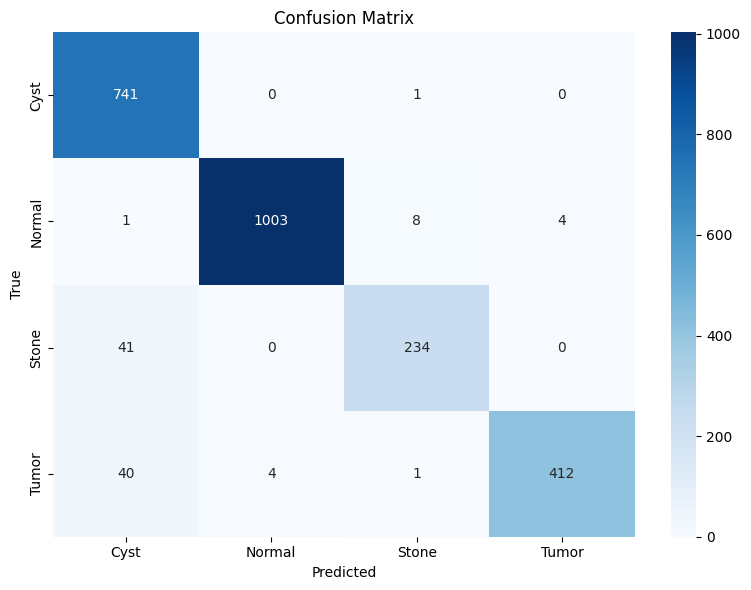

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true and predicted labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


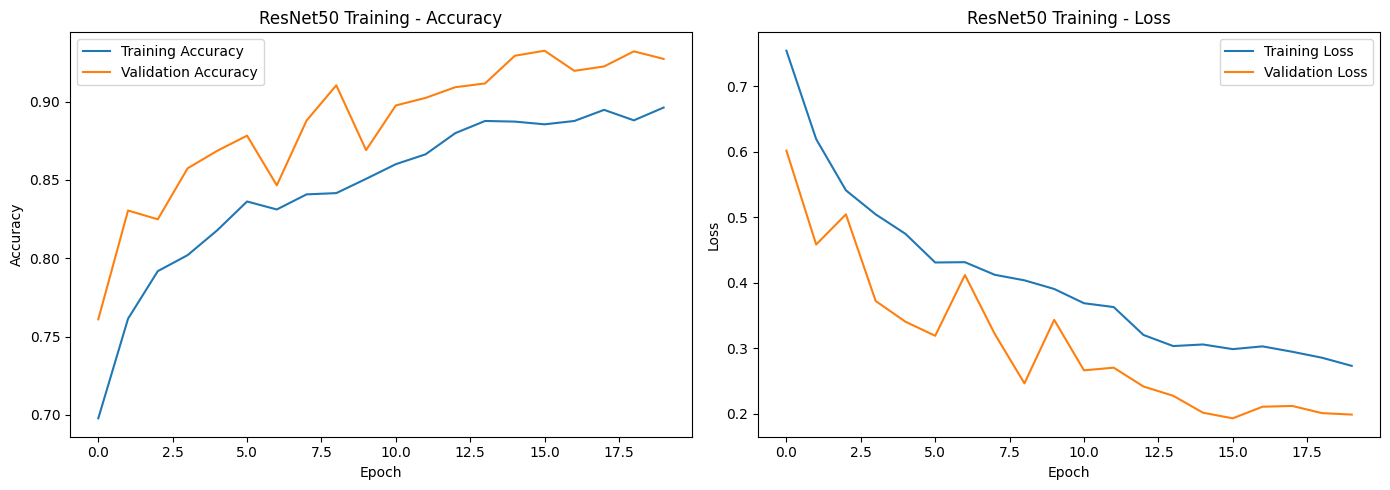

In [65]:
def plot_training(history, title="Model Training"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot after training
plot_training(history, title="ResNet50 Training")


In [14]:
model.save("final_resnet50_model.h5")  # Saves architecture, weights, and optimizer state
print("Model saved resnet50")

Model saved resnet50


# Inseptionv3

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle

tf.keras.backend.clear_session()


In [3]:
base_path = "/kaggle/input/kidney-imgae-dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

image_size = (299, 299)  # InceptionV3 default
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

train_generator = datagen.flow_from_directory(
    base_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


I0000 00:00:1749434997.609239      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749434997.609974      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,065,572 (84.17 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [26]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Set base path (update this)
base_path = "/kaggle/input/kidney-imgae-dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# Step 1: Clean corrupted images
bad_images = []
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    for img_file in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path)
            img.verify()
        except:
            bad_images.append(img_path)

print("Bad Images:", bad_images)

# Step 2: Setup Image Generators
image_size = (299, 299)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Step 3: Build InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop]
)

# Step 5: Evaluation
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(val_generator.classes, y_pred))

print("\nClassification Report:")
print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))


Bad Images: []
Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/15
623/623 ━━━━━━━━━━━━━━━━━━━━ 93s 124ms/step - accuracy: 0.5383 - loss: 1.1091 - val_accuracy: 0.6626 - val_loss: 0.9183
Epoch 2/15
623/623 ━━━━━━━━━━━━━━━━━━━━ 60s 97ms/step - accuracy: 0.7737 - loss: 0.6091 - val_accuracy: 0.6707 - val_loss: 0.8411
Epoch 3/15
623/623 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.8213 - loss: 0.4723 - val_accuracy: 0.6876 - val_loss: 0.7773
Epoch 4/15
623/623 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.8622 - loss: 0.3778 - val_accuracy: 0.7016 - val_loss: 0.7763
Epoch 5/15
623/623 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.8795 - loss: 0.3315 - val_accuracy: 0.7161 - val_loss: 0.7623
Epoch 6/15
623/623 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.8922 - loss: 0.2991 - val_accuracy: 0.7181 - val_loss: 0.7944
Epoch 7/15
623/623 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.9079 - loss: 0.2677 - val_accuracy: 0.6980 - val_l

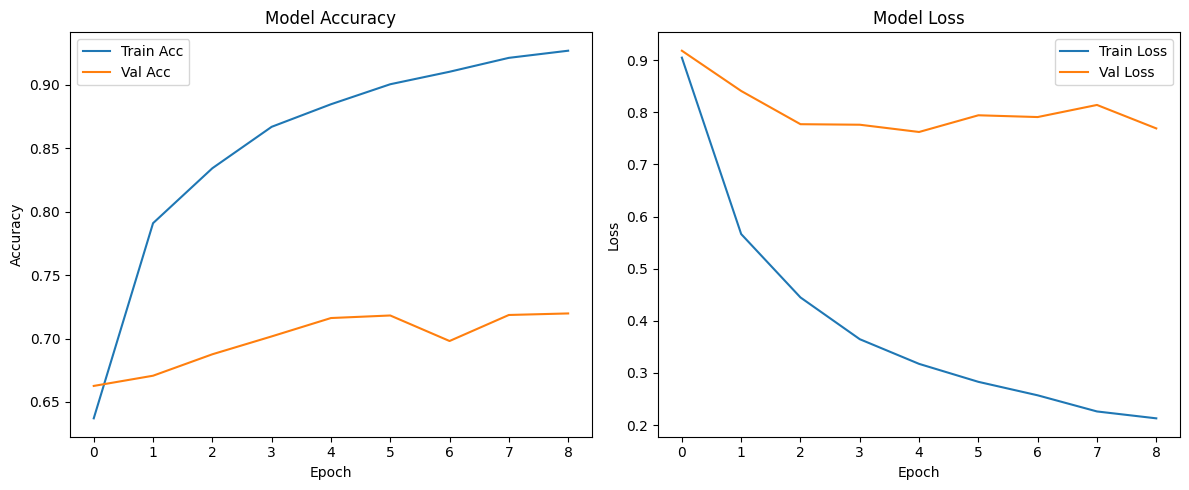

156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step


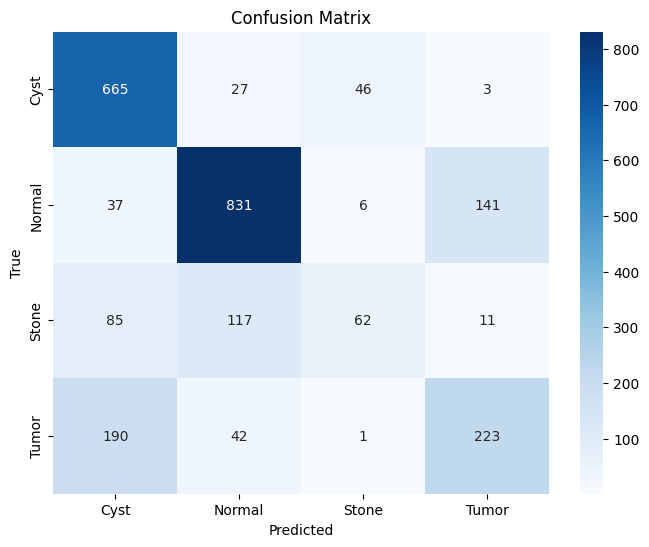

Classification Report:

              precision    recall  f1-score   support

        Cyst       0.68      0.90      0.77       741
      Normal       0.82      0.82      0.82      1015
       Stone       0.54      0.23      0.32       275
       Tumor       0.59      0.49      0.53       456

    accuracy                           0.72      2487
   macro avg       0.66      0.61      0.61      2487
weighted avg       0.70      0.72      0.70      2487



In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ✅ Plot accuracy & loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ✅ Confusion Matrix
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
class_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ✅ Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [29]:
model.save('/kaggle/working/inception_v3_kidney_model.h5')
print("inceptionv3_kidney_model.h5 saved")

inceptionv3_kidney_model.h5 saved
